In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat
from scipy.sparse import bsr_matrix

from geo_annulus import *
#from multipatch_block_handler import *
from plots import *
from ass_nonlin_el import *
from solver import *
from line_search import *


Populating the interactive namespace from numpy and matplotlib
OK


In [2]:
p = 3  # spline degree 
x_el= 24
y_el= 4
n_el = (x_el, y_el) #  isotropic material
# displacement space: degree p,   continuity p-1
multi= 1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
#m_u = tuple(kv.numdofs for kv in kvs_u)
#kvs_ref= tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi).refine() for n in n_el)

In [3]:
r_in = 1.93 #mm
r_out = 2.25 #mm
geos = geo_annulus(r_in, r_out)

In [4]:
patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True)

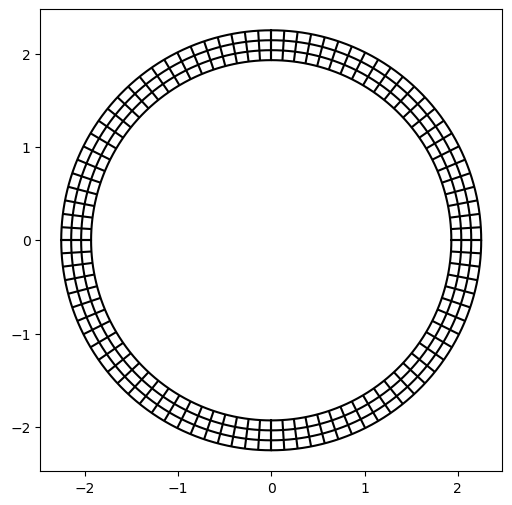

In [5]:

fig, ax = plt.subplots(figsize=(8,6))
for g in geos:
    vis.plot_geo(g, gridx=np.linspace(0, 1, x_el), gridy=np.linspace(0, 1, y_el))
ax.axis('scaled');


In [6]:
## set blocks for x and y component

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )


In [7]:
# source term f 
def f(x, y): return (0.0, 0.0)

#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
def gN(x, y): 
    return (x/r_in*l_val, y/r_in*l_val)  #inner  pressure, normalized vector

# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)


# Robin BC
def g_robin(x, y): return 0 # hom. Robin bd cond
    #return ( 1-(x/r_out+ y/r_out)**2) # scalar value
    

In [8]:

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero ) 
])


In [9]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [10]:
#incremental loading
# pressure: 13.33 kPa --> 100mmHg
#           10.664 kPa --> 80mmHg
# p_int:    2.666 kPa ---> 20mmHg
maxload = 6.666e-3#2.666e-3 #1.5e-3 #13.33*1e-3 #1.5e-2 #2e-3
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [11]:
#alpha =1e-2# 1.5e3# 1e0 # 1e4 max penalization!

def alpha(x, y): return ( 1-(x/r_out+ y/r_out)**2) * 1e-2 # scalar value

robin_data = [(1, 'right', g_robin, alpha)] # instead of Dirichlet-bdc, outer bd fixed

#robin_data = [(1, 'right', g_zero, 1)] # instead of Dirichlet-bdc, outer bd fixed

In [12]:
# assemble Robin-matrix
AR = ass_Robin(MP_block, robin_data)

In [13]:
def J(u):
    return ass_energy(u, MP_block, kvs_j, neu_data, robin_data)


def grad_J(u):
    return -ass_rhs_RN(u, MP_block, neu_data, AR)


Compiling /home/hilbert/heigl/.cache/pyiga/modules/mod07a7bed3894341a9.pyx because it changed.
[1/1] Cythonizing /home/hilbert/heigl/.cache/pyiga/modules/mod07a7bed3894341a9.pyx


In file included from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/hilbert/heigl/.cache/pyiga/modules/mod07a7bed3894341a9.c:776:
/home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


Residual0 = 0.0702115458265599
Energy0   = 0.0
Error= 0.2934923631382647
Energy    = -0.01840850162578484


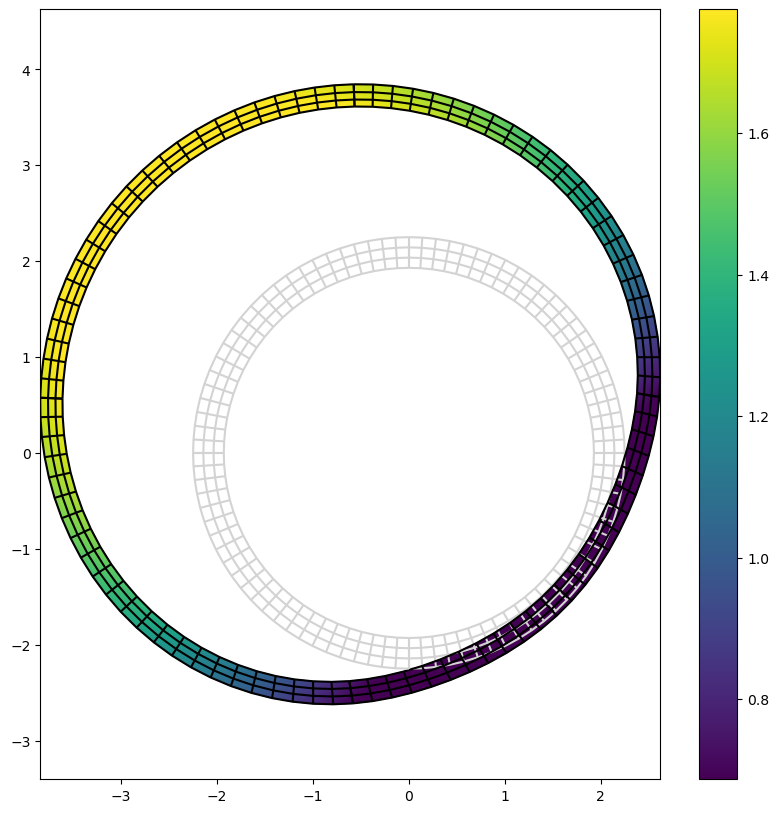

In [14]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

### first iteration ###
A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR) # with Robin-matrix
#S,sig= ass_cauchystress(u, MP_block) 

M = ass_mass(MP_block)
Minv = make_solver(M)

r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(A).dot(b) 
u += u_d

w= np.inner(np.transpose(u_d),b)
err = np.sqrt(np.abs(w))
print('Error=', err)

#A, b = ass_nonlinsystem(u, MP_block, neu_data, AR) 
#b= ass_rhs_RN( u, MP_block, neu_data, AR)
#print('rhs:', b)

#r = np.transpose(b).dot(Minv.dot(b)) #L2-norm
#print('Residual  =', r)
print('Energy    =', J(u))



###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

 
 
 1. loading: 0.002222 

0
Energy   = 0.0
Error= 0.0978307877127549
1
Energy   = -0.003996696058213705
Error= 0.02139434079892024
2
Energy   = -0.004231678064796253
Error= 0.0012657741572637804
3
Energy   = -0.004232485994194594
Error= 2.070786564824413e-05
4
Energy   = -0.004232486250205453
Error= 7.902374078152782e-09
5
Energy   = -0.004232486250213491
Error= 1.3932981942521728e-15
u=  [0.11354963 0.11057559 0.1050369  ... 0.18170186 0.18158683 0.18152913]
 
 
 2. loading: 0.004444 

0
Energy   = -0.012266056134983362
Error= 0.08317969026940712
1
Energy   = -0.015432287443127166
Error= 0.011195338823817893
2
Energy   = -0.015495458782802776
Error= 0.0001484901762662483
3
Energy   = -0.01549546919547531
Error= 3.400457476117939e-08
4
Energy   = -0.015495469195281292
Error= 3.5999331330572316e-15
u=  [0.20497658 0.19867247 0.18721439 ... 0.321444   0.32129161 0.321215  ]
 
 
 3. loading: 0.006666 

0
Energy   = -0.029793576988010984
Error= 0.07579802011706109
1
Energy   = -0.0325180

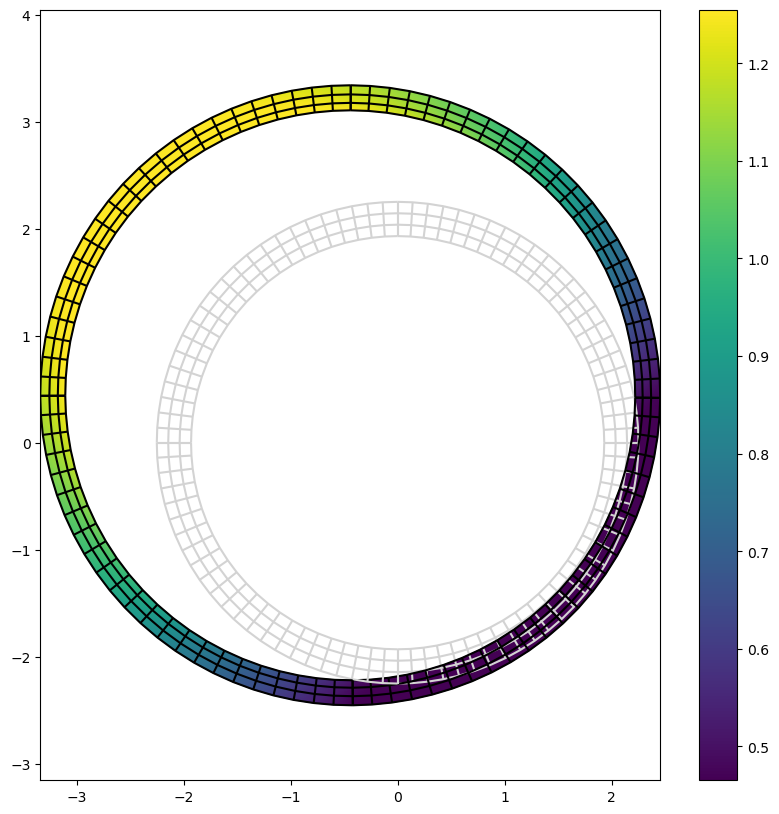

In [15]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []
vol= []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while True:
        print(count)
        
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        print('Energy   =',J(u))
        u_d = make_solver(A).dot(b)
        ## error measure in H1*
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)
        
        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if abs(err) < max_err:
            break
        elif count == 20:
            break
        
        count+=1
        #update solution
        u += u_d  
        
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
    
    loc_vol= local_vol (u, MP_block)
    vol.append(loc_vol)
    
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [16]:
sum(iter_counts)

14

4it [00:00,  4.79it/s]                                                                                                                                      


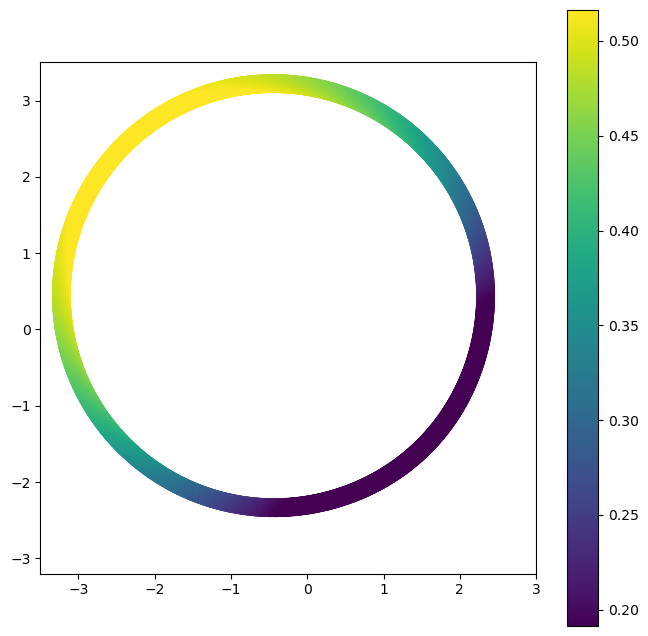

In [17]:
from IPython.display import HTML

figsize(14, 4)
s_sol= shape(solutions)[0]
fields = [solutions[tt] for tt in range(s_sol)]
HTML(animate_field(fields, patches_u, kvs_u, MP_u, res=(50,70), interval=635, progress=True).to_html5_video())

 
 
 1. loading: 0.002222 

1
Residual = 0.007801282869617768
Energy   = 0.0
Error= 0.09783078771275498
 
 
 2. loading: 0.004444 

1
Residual = 0.024632499752133774
Energy   = -0.013568289396705471
Error= 0.06289397356033927
 
 
 3. loading: 0.006666 

1
Residual = 0.018148818692240592
Energy   = -0.03001802247012964
Error= 0.07199650556716113
residual = 0.004050626750424148
energy   = -0.03251773987088508
Error= 0.008792898763244647
1
residual = 3.612018916198135e-05
energy   = -0.03255737205601199
Error= 0.0005372672634559257
2
residual = 1.1781520525679154e-08
energy   = -0.03255752013520325
Error= 8.117234391465262e-06
3
residual = 1.2282705168160143e-15
energy   = -0.032557520199949175
Error= 2.4878833062970966e-09
4
residual = 8.959554097792762e-29
energy   = -0.03255752019995824
Error= 5.947454392683638e-16
u=  [0.28974853 0.27874253 0.25996794 ... 0.43811142 0.43795124 0.43787037]


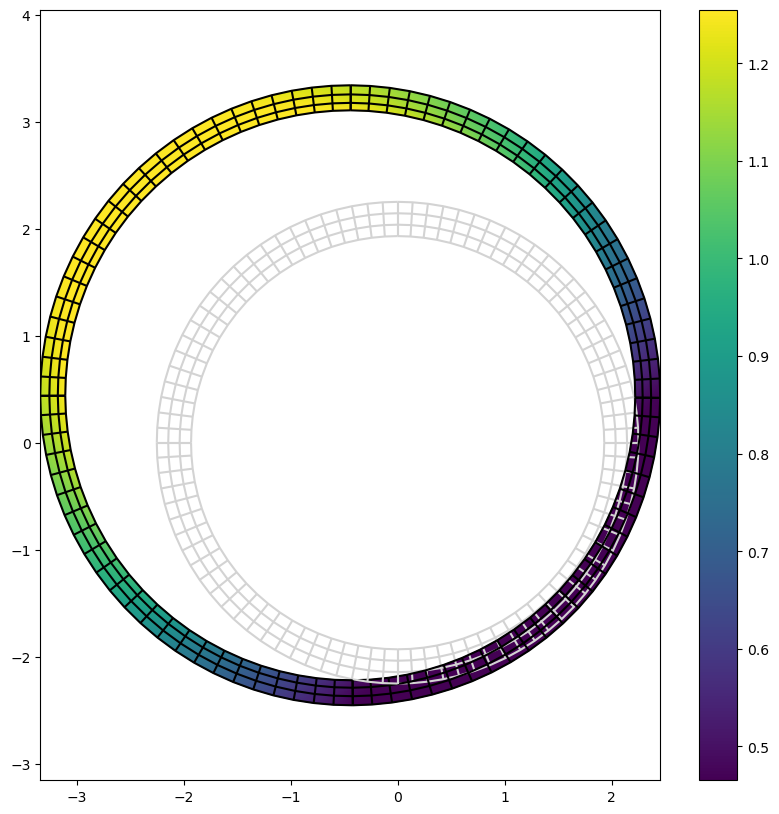

In [18]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)
u_d= u

epsilon= 1e-11# 1e-5
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while count <len(loading)-2:
        count+=1
        print(count)
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
       
        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(A).dot(b)
        u += u_d  
        
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)
        
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        

    solutions.append(np.array(u))
    iter_counts.append(count)
    count=0

# solve solution exact on max. loading 
while True:
    A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
    r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm

    print('residual =', r)
    print('energy   =', J(u))
    
    # # solve system # #
    u_d = make_solver(A).dot(b)
    
    w= np.inner(np.transpose(u_d),b)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 20:
        break
    
    count+=1 # count only, when system is solved
    print(count)
    # update u
    u += u_d 
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#
    
ud_array.append(u_d) 
print('u= ' , u)
solutions.append(np.array(u))
iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [19]:
sum(iter_counts)

7


 patch: 0
inner radius_0= 2.258982955087107
outer radius_0= 2.4883035236941735
displacement_inner= [0.28945382 0.42074785]
displacement_outer= [0.20285565 0.41851354]
dis_inner_x/dis_outer_x:  1.4268955026699308
dis_inner_y/dis_outer_y:  1.0053386754777385
 ratio_inner: 1.1704574896824387
 ratio_outer: 1.1059126771974104

 patch: 1
inner radius_0= 2.258982955087108
outer radius_0= 2.4883035236941744
displacement_inner= [-0.42074785 -0.28945382]
displacement_outer= [-0.41851354 -0.20285565]
dis_inner_x/dis_outer_x:  1.005338675477739
dis_inner_y/dis_outer_y:  1.42689550266993
 ratio_inner: 1.1704574896824396
 ratio_outer: 1.1059126771974108

 patch: 2
inner radius_0= 3.135885396015
outer radius_0= 3.3675127313428717
displacement_inner= [-1.17503387  0.43879594]
displacement_outer= [-1.08892371  0.43787037]
dis_inner_x/dis_outer_x:  1.0790782321083765
dis_inner_y/dis_outer_y:  1.0021138012008646
 ratio_inner: 1.6248110860181348
 ratio_outer: 1.4966723250412763

 patch: 3
inner radius_0=

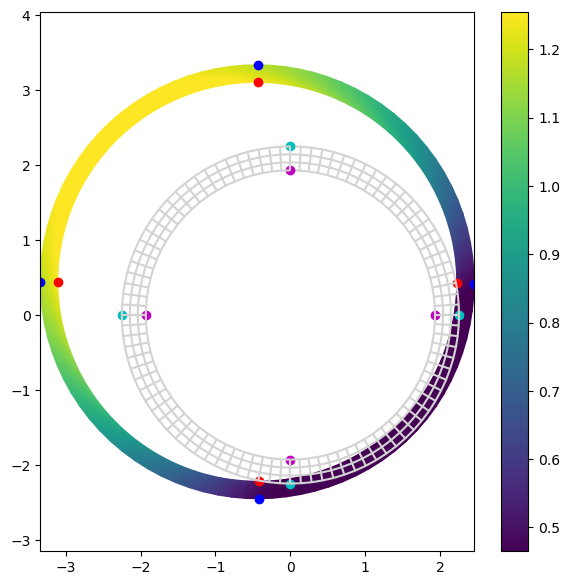

In [20]:
get_defplotPP(u, patches_u, kvs_u, MP_u, n_el, r_in, r_out)

In [21]:
iter_counts

[1, 1, 1, 4]

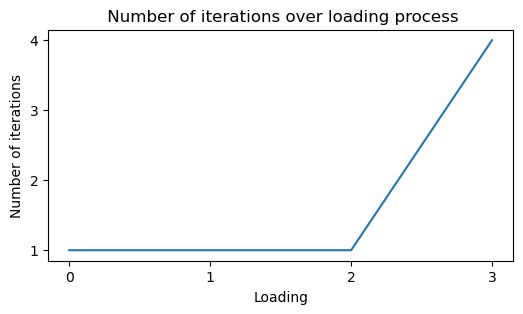

In [22]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [23]:
cs = cauchystress(u, MP_block)

In [24]:
max(cs)

0.005991682873110534

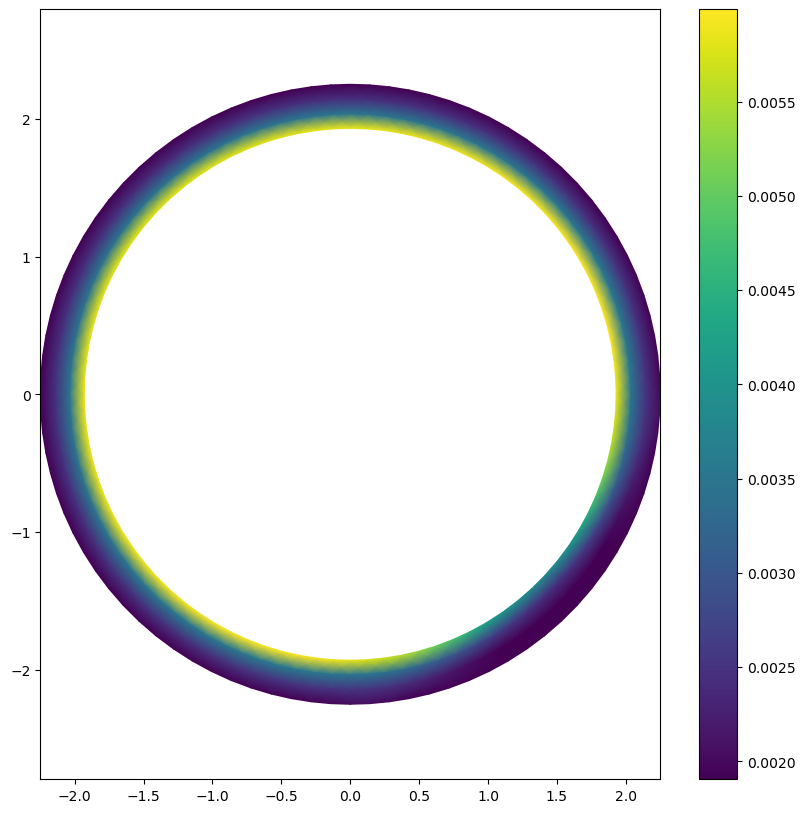

In [25]:
# Cauchy-stress
get_defplot_scalar(cauchystress(u, MP_block), patches_u, kvs_u, MP_u, n_el, geos)

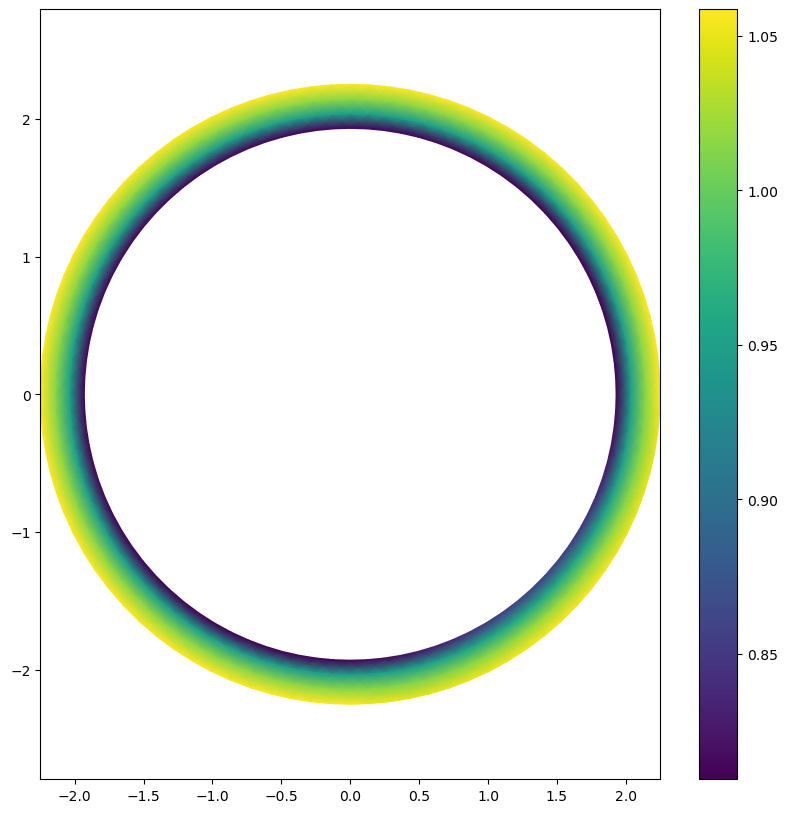

In [26]:
# local volume
get_defplot_scalar(local_vol(u, MP_block), patches_u, kvs_u, MP_u, n_el, geos)


 patch: 0
cauchystress_inner= 0.0058635669674450466
cauchystress_outer= 0.002020411062737643
volume_inner= 0.812211502422158
volume_outer= 1.0576800959995627

 patch: 2
cauchystress_inner= 0.0058540982412020855
cauchystress_outer= 0.001905225400030749
volume_inner= 0.8123941521742946
volume_outer= 1.058651487388785


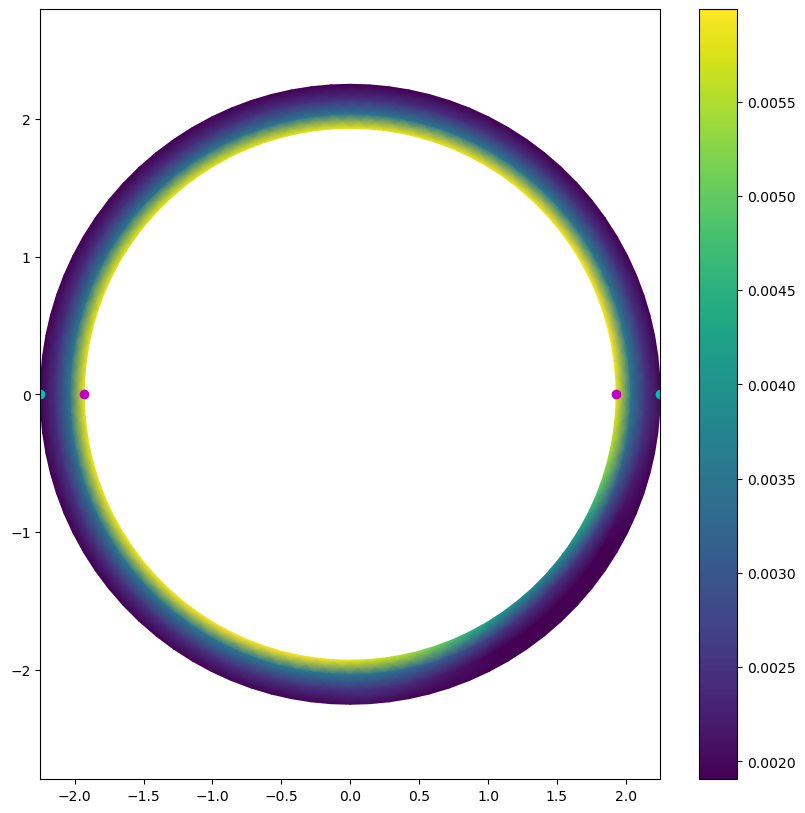

In [27]:
get_defplot_evalp(cauchystress(u, MP_block), local_vol(u, MP_block), patches_u, kvs_u, MP_u, n_el)

 without loading

0
Energy   = 0.0
Error= 0.2934923631382647
1
Energy   = -0.01840850162578484
Error= 0.160383895838107
2
Energy   = -0.03227398753614533
Error= 0.023392702096671426
3
Energy   = -0.032556371076807006
Error= 0.0015120331670797403
4
Energy   = -0.032557520066413714
Error= 1.4819338481803751e-05
5
Energy   = -0.03255752019995527
Error= 1.9524148994766145e-09
6
Energy   = -0.03255752019995824
Error= 5.297466225525575e-16
u=  [0.28974853 0.27874253 0.25996794 ... 0.43811142 0.43795124 0.43787037]


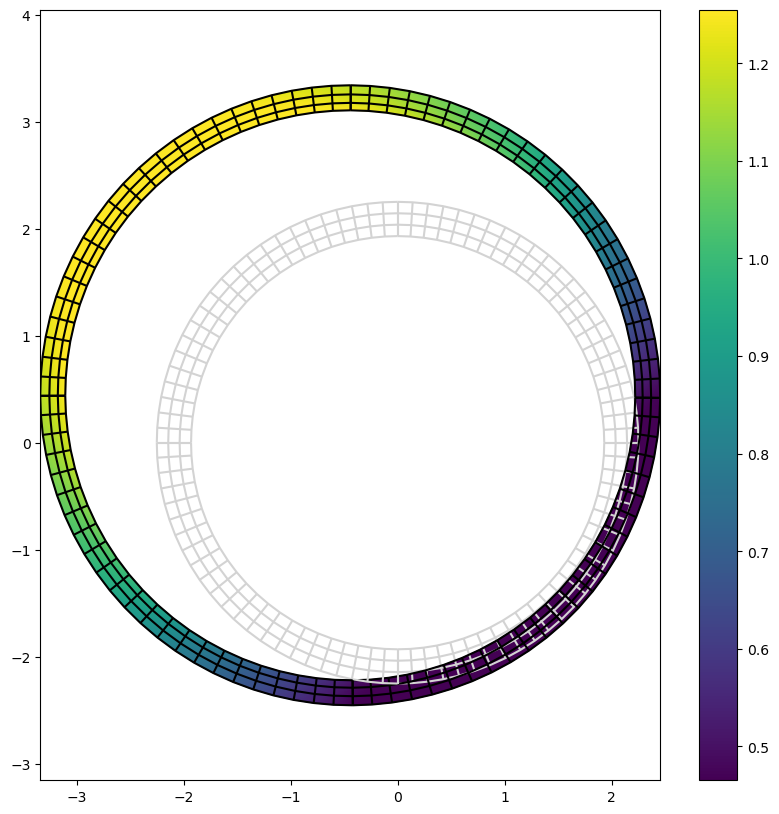

In [28]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []
vol= []

print(" without loading\n")

# set Neumann data via incremental loading
l_val = loading[-1]
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

count = 0
while True:
    print(count)
    A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
    print('Energy   =',J(u))
    u_d = make_solver(A).dot(b)
    
    ## error measure in H1*
    w= np.inner(np.transpose(u_d),b)
    err = np.sqrt(np.abs(w))
    print('Error=', err)

    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#

    #if r < epsilon * r0: # break condition
    if abs(err) < max_err:
        break
    elif count == 20:
        break
        
    count+=1
    u += u_d  

ud_array.append(u_d) 
print('u= ' , u)
solutions.append(np.array(u))
iter_counts.append(count)

loc_vol= local_vol (u, MP_block)
vol.append(loc_vol)
       
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [29]:
sum(iter_counts)

6

In [30]:
vol_ratio= global_vol (u, MP_block, kvs_j)

In [31]:
vol_ratio

0.9762903979377865

In [32]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

    dis = get_components(X.T @ u, kvs_ux)
    detF= sum(assemble.assemble( '(tr(grad(dis))+2)  * aux * dx',kvs_ux, bfuns=[('aux',1)], geo=geo_ux, dis=dis).ravel())
    print(detF)

2.1687431588635135
2.1643147836043113
2.1687431588635135
2.16876682606679


In [33]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
    kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration
    dis = get_components(X.T @ u, kvs_ux)
    #print(dis)
    detF= sum(assemble.assemble( '((1+grad(dis)[0,0]) *(1+grad(dis)[1,1])-grad(dis)[0,1]*grad(dis)[1,0])* aux * dx',kvs_j, bfuns=[('aux',1)], geo=geo_ux, dis=dis).ravel())
    print(detF)

1.024623253717626
1.0280478507787407
1.024623253717626
1.0252676197937234


In [34]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
    kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration
    dis = get_components(X.T @ u, kvs_ux)
    detF= sum(assemble.assemble( '((1+grad(dis)[0,0]) *(1+grad(dis)[1,1]))* aux * dx',kvs_j, bfuns=[('aux',1)], geo=geo_ux, dis=dis).ravel())
    print(detF)

1.0725053517921375
1.068132166222126
1.0725053517921375
1.0727039228630777


In [35]:
vol_ratio= global_vol(u, MP_block, kvs_j)

In [36]:
vol_ratio

0.9762903979377865

In [37]:
r_in*r_in *np.pi

11.70211847535662

In [38]:
r_out*r_out *np.pi

15.904312808798327

In [39]:
def vol_undef(r_inner=r_in, r_outer=r_out):
    return (r_outer**2 - r_inner**2) *np.pi

In [40]:
vol_undef()

4.202194333441708

Norm of rhs for max loading: 0.0702115458265599
Tolerance:                   7.02115458265599e-13
 
 
 1. loading: 0.002222 

Residual = 0.007801282869617768
Energy   = 0.0
1
residual = 0.00559051296679751
energy   = -0.003996696058213705
Error= 0.04929044792162365
 
 
 2. loading: 0.004444 

Residual = 0.02463249975213433
Energy   = -0.013568289396705447
1
residual = 0.0023310200143236296
energy   = -0.015471636230950112
Error= 0.015279210770841696
 
 
 3. loading: 0.006666 

Residual = 0.018148818692240654
Energy   = -0.03001802247012959
1
residual = 0.004050626750424308
energy   = -0.03251773987088509
Error= 0.017065338360580544
1
residual = 3.612018916198521e-05
energy   = -0.03255737205601199
Error= 0.001705744465461251
2
residual = 1.1781520525664212e-08
energy   = -0.03255752013520325
Error= 6.329064307951549e-05
3
residual = 1.2282705611319358e-15
energy   = -0.032557520199949175
Error= 1.4073087480241844e-07
4
residual = 9.651043081221746e-29
energy   = -0.03255752019995824
Er

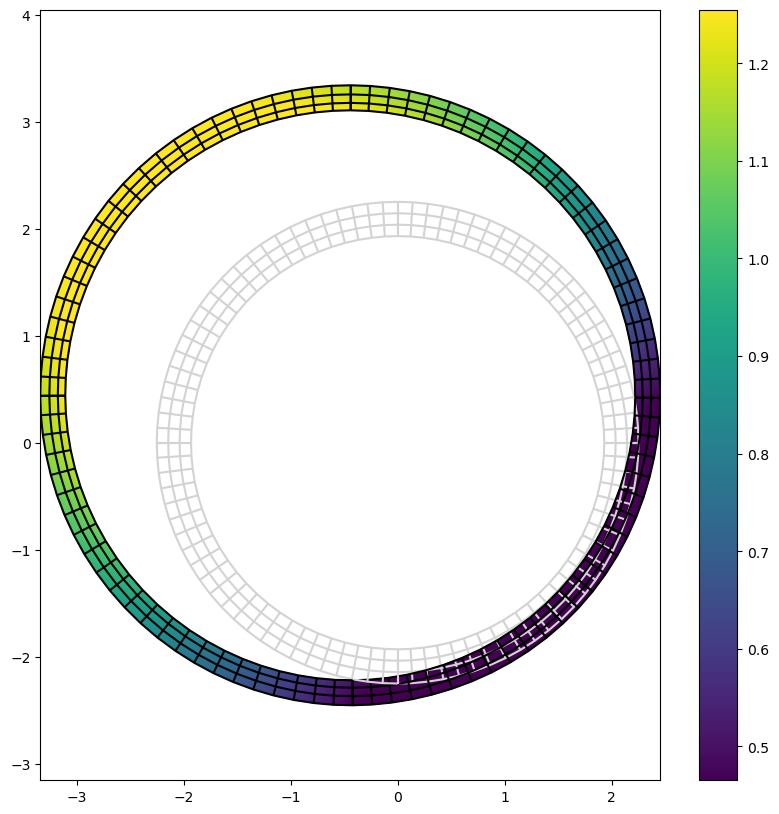

In [41]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

epsilon= 1e-11# 1e-5
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
#M = ass_mass(MP_block)
#Minv = make_solver(M)
r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
#r0 = np.linalg.norm(b)


print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while count <len(loading)-2:
        count+=1

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
            r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
            print('Residual =',r)
            print('Energy   =',J(u))
        #else: # Use from last iteration; see below (*)
            
        print(count)

        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(A).dot(b)
        u += u_d          

        # Compute new non-linear residual, already to be used for next iteration (*)
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
            
        print('residual =', r)
        print('energy   =', J(u))
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)
        
        
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
    solutions.append(np.array(u))
    iter_counts.append(count)
    count=0

while True:
    count+=1

    # Assemble matrices and rhs in every iteration step
#     if count == 1:
#         A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
#         r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
#         print('Residual =',r)
#         print('Energy   =',J(u))
    #else: # Use from last iteration; see below (*)
    print(count)

    # # solve system # #
    u_d = make_solver(A).dot(b)
    u += u_d          

    # Compute new non-linear residual, already to be used for next iteration (*)
    A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
    r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm

    print('residual =', r)
    print('energy   =', J(u))

    w= np.inner(np.transpose(u_d),b)
    err = np.sqrt(np.abs(w))
    print('Error=', err)


    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#

    #if r < epsilon * r0: # break condition
    if abs(err) < max_err:
        break
    elif count == 20:
        break
    #
ud_array.append(u_d) 
print('u= ' , u)
solutions.append(np.array(u))
iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [42]:
plt.clf()

<Figure size 600x300 with 0 Axes>

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
res=(50,70)
#vrange=(0.0, 1.5e-3)

s_sol= shape(solutions)[0]
ims = []
ar= np.linspace(1,2, s_sol)
factor = 1

#fields = list(ud_array)
fields = list(solutions)

for tt in range(s_sol):
    #u = LS.complete(fields[tt])
    u = fields[tt]
    #factor = ar[tt] # choose factor for deformation plot
    vrange = None
    ims_q = []
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:]

    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
            for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
            for p in range(len(patches_u))]
    plt.ioff()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        im_q=[]
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            #vrange = (0.0, 1.5e-3)
            vrange = (C.min(), C.max())
        im_q = plt.pcolormesh(XY[..., 0] + factor*dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1], axes=ax) # shading for smoothing
        
        im_q.set_array(C.ravel()) 
        ims_q.append(im_q) 
    
    ims.append(ims_q)
    #print(shape(ims))
#print(ims[0])
    
#fig.colorbar(im_q, ax=ax);
colorbar();
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat= False) # repeat_delay=2000



#ani.to_html5_video()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'))
#ani.save("rtest.mp4", writer=writer )
vid = ani.to_html5_video()
# saving to m4 using ffmpeg writer
#writervideo = animation.FFMpegWriter(fps=500)
#ani.save('Robin_15.mp4', writer=writervideo)

plt.close()



In [44]:
ani